<a href="https://colab.research.google.com/github/garylau1/Generative_model/blob/main/Generative_cartoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic:GAN for generating cartoon

## Introduction:

Generative Adversarial Networks (GANs) have revolutionized the field of image synthesis, enabling the creation of highly realistic and diverse images. In this project, I develop a GAN model from scratch to generate cartoon avatars, using the Cartoon Set dataset available on Kaggle.

The Cartoon Set dataset comprises a collection of random 2D cartoon avatar images with variations across ten artwork categories, four color categories, and four proportion categories, offering approximately 1013 possible combinations. The dataset provides two subsets containing 10,000 and 100,000 labeled images, each at a resolution of 500x500 pixels.

To optimize memory usage, I converted the original PNG images into the JPG format while retaining the visual quality. These converted images are organized into ten subfolders, each containing 10,000 images. This preprocessing step ensures the dataset is more manageable for efficient loading and processing during GAN training.

This report details the development process, including dataset preparation, GAN architecture design, training strategies, and results. The ultimate goal is to produce diverse and visually appealing cartoon avatars through adversarial learning.

https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set

In [ ]:
import torch
import torch.nn as nn

import torchvision
import numpy
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

Unzipping the cartoon.zip file to extract its contents into the current working directory:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Create a folder in the current directory
folder_name = "Dataset"
os.makedirs(folder_name, exist_ok=True)

print(f"Folder '{folder_name}' created successfully!")

Folder 'Dataset' created successfully!


In [ ]:
import shutil

# Define the source and destination paths
source_path = '/content/drive/MyDrive/cartoon.zip'
destination_path = '/content/Dataset'

# Copy the file
shutil.copy(source_path, destination_path)
print("File copied to /content successfully!")

File copied to /content successfully!


In [ ]:
!unzip /content/drive/MyDrive/cartoon.zip -d /content/Dataset




Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/cartoonset10k/cs10755719035366634500.png  
  inflating: /content/Dataset/cartoonset10k/cs10755748941826833799.png  
  inflating: /content/Dataset/cartoonset10k/cs10755957224249545546.png  
  inflating: /content/Dataset/cartoonset10k/cs1075609143194812341.png  
  inflating: /content/Dataset/cartoonset10k/cs10756219695542318383.png  
  inflating: /content/Dataset/cartoonset10k/cs10756288549453457405.png  
  inflating: /content/Dataset/cartoonset10k/cs10756327220067079832.png  
  inflating: /content/Dataset/cartoonset10k/cs10756991518761997041.png  
  inflating: /content/Dataset/cartoonset10k/cs10757362374146439820.png  
  inflating: /content/Dataset/cartoonset10k/cs10757675124958983592.png  
  inflating: /content/Dataset/cartoonset10k/cs10757999797523659567.png  
  inflating: /content/Dataset/cartoonset10k/cs10758021930561957001.png  
  inflating: /content/Dataset/cartoonset10k/cs10758037387654375729.png  
 

In [ ]:
os.remove("/content/Dataset/cartoon.zip")

## Data-Preprocessing:

To effectively train the Generative Adversarial Network (GAN), it is crucial to organize and preprocess the dataset into a form suitable for deep learning models. This section focuses on loading the car image dataset using PyTorch's torchvision.datasets.ImageFolder class and applying preprocessing transformations to standardize the data for input to the model. The dataset is then wrapped into PyTorch DataLoader objects to facilitate efficient batch-wise data loading during training and testing. These steps ensure that the images are correctly formatted and accessible in a manner conducive to high-performance model training.

In [ ]:

from torch.utils.data import DataLoader

image_size=28
batch_size=64
decide=False   #decide whether we need to shuffle the images or not
dis_par=0.01   # for weight clipping in later stage
channel=3      #channels of image

# Loading the training dataset from the specified directory and applying transformations:
# - ToTensor: Converts the image to a PyTorch tensor and normalizes pixel values to [0, 1].
# - Resize: Resizes all images to a uniform size of 64x64 pixels.
trainset = torchvision.datasets.ImageFolder(
    root=destination_path,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((image_size, image_size))
    ])
)



# Importing the DataLoader class from PyTorch for handling dataset batches.
from torch.utils.data import DataLoader

# Creating a DataLoader for the training dataset:
# - batch_size=32: Divides the dataset into mini-batches of 32 images.
# - shuffle=True: Randomly shuffles the dataset at the start of each epoch for better training.
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=decide)

# Creating a DataLoader for the testing dataset:
# - batch_size=32: Divides the dataset into mini-batches of 32 images.
# - shuffle=False: Keeps the dataset order intact for evaluation purposes.


print (len(train_dataloader))

157


## Generator:

The generator in a Generative Adversarial Network (GAN) is a neural network designed to create synthetic data that mimics the real dataset. In this section, a key building block of the generator, the GenBlock class, is defined. This block consists of a linear layer followed by a ReLU activation function, which enables the model to learn complex data representations. By modularizing the architecture, the generator becomes flexible and easier to construct, maintain, and expand for specific tasks such as generating realistic car images.

In [ ]:


# Importing the necessary library for defining neural network modules
import torch.nn as nn

# Defining a generator block as a modular component of the generator network
class GenBlock(nn.Module):
    def __init__(self, in_feature, out_feature):
        """
        Initializes the GenBlock module with a linear layer and ReLU activation.

        Args:
            in_feature (int): The number of input features to the linear layer.
            out_feature (int): The number of output features from the linear layer.
        """
        super().__init__()  # Initialize the parent class
        # Define a sequential block with:
        # - A linear layer to transform input to the desired output size.
        # - A ReLU activation function to introduce non-linearity.
        self.main = nn.Sequential(
            nn.Linear(in_feature, out_feature),  # Fully connected layer
            nn.ReLU(inplace=True)  # ReLU activation to add non-linearity
        )

    def forward(self, x):
        """
        Forward pass of the generator block.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor after applying the linear transformation and ReLU activation.
        """
        return self.main(x)  # Pass the input through the defined block



 The Generator class defines the overall architecture of the generator network, built as a series of GenBlock layers followed by a final linear layer and a Tanh activation function. This design enables the generator to transform random noise into high-dimensional image data. The final output is reshaped into the format of RGB images with dimensions
3
×
64
×
64
3×64×64, making it compatible with the car image dataset used in this project.

In [ ]:
# Importing the necessary library for defining neural network modules
import torch.nn as nn

# Defining the Generator class, which builds the full generator network
class Generator(nn.Module):
    def __init__(self):
        """
        Initializes the Generator network, which consists of multiple GenBlocks,
        a final linear layer, and a Tanh activation function.

        The generator transforms a random noise vector (latent space) into a
        realistic RGB image with dimensions 3x64x64.

        Architecture:
        - GenBlock(100, 256): Expands latent vector to 256 features.
        - GenBlock(256, 512): Further expands to 512 features.
        - GenBlock(512, 1024): Further expands to 1024 features.
        - Linear(1024, 3*64*64): Maps features to a flattened image representation.
        - Tanh(): Normalizes pixel values to the range [-1, 1].
        """
        super().__init__()  # Initialize the parent class
        # Define the generator network as a sequence of layers
        self.main = nn.Sequential(
            GenBlock(100, 256),    # First block: Latent space to 256 features
            GenBlock(256, 512),   # Second block: 256 to 512 features
            GenBlock(512, 1024),  # Third block: 512 to 1024 features
            nn.Linear(1024, channel * image_size * image_size),  # Fully connected layer for image output
            nn.Tanh()  # Tanh activation for output normalization
        )

    def forward(self, x):
        """
        Forward pass of the Generator network.

        Args:
            x (Tensor): Input tensor representing random noise (latent space).

        Returns:
            Tensor: Output tensor reshaped into RGB image format (batch_size, 3, 64, 64).
        """
        # Pass the input through the defined generator network
        return self.main(x).view(-1, channel, image_size, image_size)  # Reshape the output to image dimensions


## Discriminator:

The discriminator in a Generative Adversarial Network (GAN) serves as a classifier, distinguishing between real images from the dataset and synthetic images generated by the generator. To build the discriminator network, the DisBlock class is introduced as a reusable building block. Each block consists of a linear layer for feature transformation, a LeakyReLU activation function to prevent the dying ReLU problem by allowing small gradients for negative inputs, and a dropout layer to improve generalization by preventing overfitting. This modular design ensures the discriminator is effective in learning features that differentiate between real and fake images.

In [ ]:
# Importing the necessary library for defining neural network modules
import torch.nn as nn

# Defining a discriminator block as a modular component of the discriminator network
class DisBlock(nn.Module):
    def __init__(self, in_feature, out_feature):
        """
        Initializes the DisBlock module with a linear layer, LeakyReLU activation,
        and a dropout layer for regularization.

        Args:
            in_feature (int): The number of input features to the linear layer.
            out_feature (int): The number of output features from the linear layer.
        """
        super().__init__()  # Initialize the parent class
        # Define a sequential block with:
        # - A linear layer for transforming input to the desired output size.
        # - LeakyReLU activation to mitigate the dying ReLU problem and allow small gradients for negative inputs.
        # - Dropout to randomly deactivate neurons during training, reducing overfitting.
        self.main = nn.Sequential(
            nn.Linear(in_feature, out_feature),    # Fully connected layer
            nn.LeakyReLU(0.2, inplace=True),       # LeakyReLU activation with a slope of 0.2 for negative inputs
            nn.Dropout(0.2)                        # Dropout with a 20% probability
        )

    def forward(self, x):
        """
        Forward pass of the discriminator block.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor after applying the linear transformation, LeakyReLU, and dropout.
        """
        return self.main(x)  # Pass the input through the defined block

The Discriminator class builds the full architecture of the discriminator network, which consists of multiple DisBlock layers for feature extraction, followed by a final linear layer and a sigmoid activation function to output a probability score between 0 and 1.


In [ ]:
# Defining the Discriminator class, which builds the full discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        """
        Initializes the Discriminator network, which classifies input images
        as real or fake. The network consists of multiple DisBlocks for feature
        extraction and a final sigmoid layer for binary classification.

        Architecture:
        - DisBlock(3*64*64, 1024): Flattens input images and maps to 1024 features.
        - DisBlock(1024, 512): Reduces features from 1024 to 512.
        - DisBlock(512, 256): Further reduces features from 512 to 256.
        - Linear(256, 1): Outputs a single value representing the probability of being real.
        - Sigmoid(): Ensures output is in the range [0, 1].
        """
        super().__init__()  # Initialize the parent class
        # Define the discriminator network as a sequence of layers
        self.main = nn.Sequential(
            DisBlock(channel * image_size * image_size, 1024),  # First block: Input image (flattened) to 1024 features
            DisBlock(1024, 512),         # Second block: 1024 to 512 features
            DisBlock(512, 256),          # Third block: 512 to 256 features
            nn.Linear(256, 1),           # Final linear layer to output a single value
            nn.Sigmoid()                 # Sigmoid activation for probability output
        )

    def forward(self, x):
        """
        Forward pass of the Discriminator network.

        Args:
            x (Tensor): Input tensor representing a batch of images.

        Returns:
            Tensor: Output tensor with a probability score for each image.
        """
        # Flatten the input image tensor and pass it through the network
        return self.main(x.view(-1, channel * image_size * image_size)).view(-1)




## Training:

This part of the code represents the main training loop for a Generative Adversarial Network (GAN). It includes the training of both the generator and discriminator for a specified number of epochs. For each batch in the training dataset, the discriminator is trained first by computing its loss on real and fake images. Then, the generator is trained by updating its weights to fool the discriminator into classifying fake images as real. The code also generates and visualizes fake images at each epoch, giving a visual representation of the generator's progress.

In [ ]:
# Importing the optimizer module from PyTorch
from torch import optim

# Initialize the Generator network
Generator_ = Generator()  # Create an instance of the Generator class, responsible for generating images

# Initialize the Discriminator network
Disc = Discriminator()  # Create an instance of the Discriminator class, responsible for distinguishing real from fake images

# Define the loss function for binary classification (BCELoss)
#criterian = nn.BCELoss()  # Binary Cross-Entropy loss is used to calculate the difference between predicted and true labels (real or fake)

# Initialize the optimizer for the Generator using Adam optimizer with a learning rate of 0.0002
optimizer_g = optim.RMSprop(Generator_.parameters(), lr=0.0002)  # Adam optimizer for updating generator parameters with a learning rate of 0.0002

# Initialize the optimizer for the Discriminator using Adam optimizer with a learning rate of 0.0002
optimizer_d = optim.RMSprop(Disc.parameters(), lr=0.0002)  # Adam optimizer for updating discrimi

The provided code defines the loss functions for a Wasserstein Generative Adversarial Network (WGAN), which are essential for training the model. In WGANs, the training process involves two neural networks: the discriminator (critic) and the generator.

The discriminator is responsible for distinguishing real samples from fake samples generated by the generator. It outputs a score representing how "real" an input is, rather than a probability.
The generator aims to produce fake samples that are indistinguishable from real ones, effectively "fooling" the discriminator.
These loss functions are designed to optimize the generator and discriminator in a way that minimizes the Wasserstein distance, a measure of the difference between the real and generated data distributions. By using these functions, the WGAN ensures stable training and avoids common issues like vanishing gradients seen in traditional GANs.

The next sections provide detailed implementation and explanations for the discriminator and generator loss functions.

In [ ]:
def discriminator_loss(real_output, fake_output):
    """
    Computes the loss for the discriminator in a Wasserstein GAN (WGAN) framework.

    The discriminator's goal is to maximize the difference between its average output for real samples
    and fake samples. A negative value indicates the discriminator is successfully distinguishing
    real samples from fake ones.

    Args:
        real_output (torch.Tensor): The discriminator's predictions for real images.
                                    Higher values indicate the image is likely real.
        fake_output (torch.Tensor): The discriminator's predictions for fake images generated by the generator.
                                    Lower values indicate the image is likely fake.

    Returns:
        torch.Tensor: The discriminator loss, a scalar value. Lower loss implies better performance.
    """
    # Calculate the Wasserstein loss for the discriminator.
    return -(real_output.mean() - fake_output.mean())


def generator_loss(fake_output):
    """
    Computes the loss for the generator in a Wasserstein GAN (WGAN) framework.

    The generator's goal is to maximize the discriminator's output for fake samples,
    effectively trying to 'fool' the discriminator into classifying fake samples as real.

    Args:
        fake_output (torch.Tensor): The discriminator's predictions for fake images generated by the generator.
                                    Higher values indicate the generator is succeeding in fooling the discriminator.

    Returns:
        torch.Tensor: The generator loss, a scalar value. Lower loss implies the generator is performing better.
    """
    # Calculate the Wasserstein loss for the generator.
    return (-fake_output).mean()

Notice that:

In a WGAN, the discriminator (also called the "critic") is required to satisfy the Lipschitz continuity constraint, meaning the gradient norm of the critic function must be bounded by 1.

Weight clipping is a simple way to enforce this constraint by limiting the range of the discriminator's weights to [−c,c], where c is defined by dis_par.

Ensuring the Lipschitz constraint prevents the discriminator from being overly confident in distinguishing real and fake samples.
It stabilizes the Wasserstein distance estimation, ensuring better convergence for both the generator and discriminator.

Epoch:0, Batch:0.00, D_loss:0.0078, G_loss:-0.8234
Epoch:0, Batch:10.00, D_loss:0.0062, G_loss:-0.7950
Epoch:0, Batch:20.00, D_loss:-0.0008, G_loss:-0.7747
Epoch:0, Batch:30.00, D_loss:0.0002, G_loss:-0.7621
Epoch:0, Batch:40.00, D_loss:0.0020, G_loss:-0.7867
Epoch:0, Batch:50.00, D_loss:0.0131, G_loss:-0.8086
Epoch:0, Batch:60.00, D_loss:0.0015, G_loss:-0.8366
Epoch:0, Batch:70.00, D_loss:-0.0055, G_loss:-0.7620
Epoch:0, Batch:80.00, D_loss:-0.0009, G_loss:-0.7800
Epoch:0, Batch:90.00, D_loss:-0.0049, G_loss:-0.7817
Epoch:0, Batch:100.00, D_loss:-0.0065, G_loss:-0.7714
Epoch:0, Batch:110.00, D_loss:0.0032, G_loss:-0.7924
Epoch:0, Batch:120.00, D_loss:0.0027, G_loss:-0.8003
Epoch:0, Batch:130.00, D_loss:-0.0129, G_loss:-0.8223
Epoch:0, Batch:140.00, D_loss:-0.0066, G_loss:-0.8439
Epoch:0, Batch:150.00, D_loss:-0.0100, G_loss:-0.8434


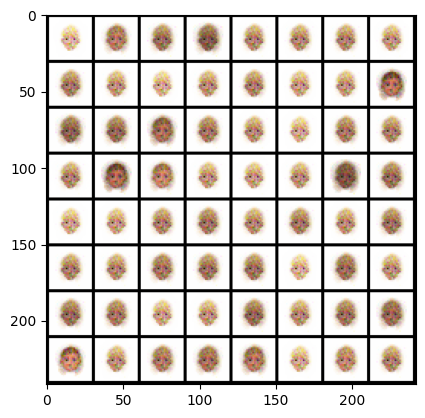

Epoch:1, Batch:0.00, D_loss:-0.0105, G_loss:-0.7567
Epoch:1, Batch:10.00, D_loss:-0.0025, G_loss:-0.7374
Epoch:1, Batch:20.00, D_loss:-0.0009, G_loss:-0.8006
Epoch:1, Batch:30.00, D_loss:-0.0019, G_loss:-0.7818
Epoch:1, Batch:40.00, D_loss:-0.0141, G_loss:-0.7853
Epoch:1, Batch:50.00, D_loss:0.0034, G_loss:-0.6707
Epoch:1, Batch:60.00, D_loss:-0.0137, G_loss:-0.5087
Epoch:1, Batch:70.00, D_loss:-0.0050, G_loss:-0.5901
Epoch:1, Batch:80.00, D_loss:0.0161, G_loss:-0.5287
Epoch:1, Batch:90.00, D_loss:0.0037, G_loss:-0.5965
Epoch:1, Batch:100.00, D_loss:0.0042, G_loss:-0.5986
Epoch:1, Batch:110.00, D_loss:0.0063, G_loss:-0.4779
Epoch:1, Batch:120.00, D_loss:0.0372, G_loss:-0.5760
Epoch:1, Batch:130.00, D_loss:0.0003, G_loss:-0.4855
Epoch:1, Batch:140.00, D_loss:-0.0141, G_loss:-0.3863
Epoch:1, Batch:150.00, D_loss:0.0142, G_loss:-0.4762


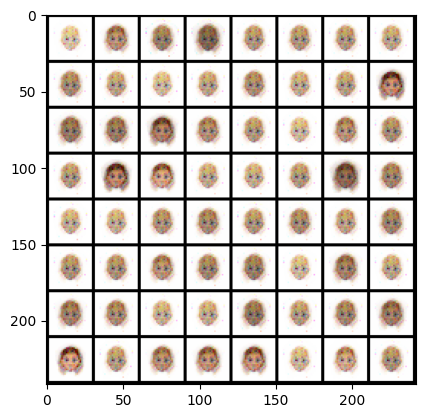

In [ ]:


# Define the number of epochs for training
epoches = 2  # Set the number of training epochs

# Create a random tensor for fake images (for visualization after training)
fake_image = torch.randn((batch_size, 100))  # Generate a random noise vector of size 32x100

# Start the training loop for each epoch
for epoch in range(epoches):
    # Loop over each batch of data in the training set
    for i, (data, _) in enumerate(train_dataloader):
        real_data = data  # Get the real data (images) from the batch
        batch_size = real_data.size(0)  # Get the batch size (number of images)

        # Create a random noise vector for generating fake images
        noise = torch.randn((batch_size, 100))  # Generate random noise (32x100)

        # Generate fake data (images) using the generator
        fake_data = Generator_(noise)  # Generate fake images by passing noise through the generator

        # Define labels for real and fake images (1 for real, 0 for fake)
        label_real = torch.full((batch_size,), 1.0)  # Real labels (1 for real images)
        label_fake = torch.full((batch_size,), 0.0)  # Fake labels (0 for fake images)

        # Discriminator outputs for real and fake images
        output_real = Disc(real_data)  # Get discriminator's output for real images
        output_fake = Disc(fake_data.detach())  # Get discriminator's output for fake images (detached to avoid updating generator)

        # Calculate the discriminator loss for real and fake images
        #loss_Dreal = criterian(output_real, label_real)  # Loss for real images
        #loss_Dfake = criterian(output_fake, label_fake)  # Loss for fake images

        # Total discriminator loss (sum of real and fake losses)
        lossD = discriminator_loss(output_real,output_fake)

        # Backpropagate and update the discriminator's weights
        optimizer_d.zero_grad()  # Reset gradients
        lossD.backward()  # Compute gradients for discriminator loss
        optimizer_d.step()  # Update discriminator's weights

        for j in Disc.parameters():
            # Clip the weights of the discriminator to enforce the Lipschitz constraint.
            # This is essential in Wasserstein GAN (WGAN) as it ensures the discriminator remains
            # a 1-Lipschitz function. The weights are constrained to a fixed range [-dis_par, dis_par].
            # Without this step, the Wasserstein distance estimation may become unstable.

            j.data.clamp_(-dis_par, dis_par)


        # Train the generator to fool the discriminator
        output_fake = Disc(fake_data)  # Get discriminator's output for fake images

        # Calculate generator's loss (how well it fools the discriminator)
        lossG = generator_loss(output_fake) # Generator loss (maximize real labels for fake images)

        # Backpropagate and update the generator's weights
        optimizer_g.zero_grad()  # Reset gradients
        lossG.backward()  # Compute gradients for generator loss
        optimizer_g.step()  # Update generator's weights



        # Print the loss every 100 batches to monitor progress
        if i % 10 == 0:
            print(f"Epoch:{epoch}, Batch:{i:.2f}, D_loss:{lossD.item():.4f}, G_loss:{lossG.item():.4f}")

    # After training each epoch, generate fake images for visualization
    with torch.no_grad():
        fake_images = Generator_(fake_image).detach()  # Generate fake images from random noise without tracking gradients

    # Create a grid of generated fake images and display it using Matplotlib
    img_grid = torchvision.utils.make_grid(fake_images)  # Create a grid from the generated images
    np_img = img_grid.numpy()  # Convert the image grid to a NumPy array
    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Display the image grid (transposing the channels for proper display)
    plt.show()  # Show the generated images





## Save our result

In [ ]:
# Importing datetime to get the current date and time
from datetime import datetime

# Get the current date and time, formatted as "YYYY-MM-DD HH:MM:SS"
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")  # Get current time and format it

# Print the current date and time
print("Current Date and Time:", current_datetime)  # Display the current date and time in the console

# Save the Generator model's state_dict (weights) to a file with the current timestamp in its filename
torch.save(Generator_.state_dict(), f"/content/weight_of_generater{current_datetime}")  # Save generator weights with timestamp

# Save the Discriminator model's state_dict (weights) to a file with the current timestamp in its filename
torch.save(Disc.state_dict(), f"/content/weight_of_discriminator{current_datetime}")  # Save discriminator weights with timestamp

Current Date and Time: 2024-12-18 19:06:57


In [ ]:
# Download multiple files (e.g., all CSV files in a directory)
import glob
for file in glob.glob('*.csv'):
  files.download(file)

## Results and Discussion

This study aimed to generate realistic images of cars using a Generative Adversarial Network (GAN). The results of the training process are presented in above, which shows a grid of 16 generated images at Epoch 7, Batch 8.

The results of training the GAN model at Epoch 45 show a significant improvement compared to the completely dark image output at Epoch 1. The grid of generated cartoon-like images, as seen above, demonstrates that the generator has learned to produce outputs with distinct features resembling human-like cartoon avatars. However, these images are still far from perfect and require further refinement.

Loss Trends at Epoch 45:
The discriminator (D_loss) and generator (G_loss) losses recorded during this epoch provide insight into the training dynamics:

Discriminator Loss (D_loss):

The discriminator loss starts slightly negative and fluctuates around zero across batches, with some occasional positive values (e.g., 0.0034 and 0.0161). This indicates that the discriminator occasionally struggles to differentiate between real and fake images, particularly as the generator improves.
Negative values in D_loss suggest that the discriminator is effectively identifying fake samples for most of the training.
Generator Loss (G_loss):

The generator loss remains consistently negative, ranging from approximately -0.7567 to -0.3863, indicating progress in generating outputs that can fool the discriminator.
However, the magnitude of G_loss reduces in later batches (e.g., Batch 140: G_loss = -0.3863), suggesting that the generator may face challenges in producing more realistic outputs as training progresses.
Discussion:

Visual Analysis of Images:

At Epoch 1, the generated images were entirely dark, indicating that the generator had no meaningful understanding of the target data distribution.
By Epoch 45, the images display recognizable shapes and colors resembling cartoon faces. Basic facial structures, such as eyes and outlines, are discernible, though fine details and sharpness are still lacking.
Training Dynamics:

The fluctuating losses and occasional clipping warning during visualization indicate that training stability remains an issue. These challenges are common in GAN training due to the adversarial nature of the loss functions.
The reduction in the generator's performance towards later batches of Epoch 45 suggests potential issues like mode collapse or vanishing gradients, which hinder the generation of diverse and high-quality images.
Model Limitations:

The generated images are blurry and lack high-resolution details. This may be due to insufficient training epochs or an inadequate network architecture for capturing fine details.
The clipping warning indicates that the output values are exceeding the valid range for RGB data, highlighting the need for improved activation functions or better normalization techniques.
Recommendations for Improvement:

Extended Training: Training the model for more epochs might enable the generator to learn finer details and improve image quality.
Architectural Enhancements: Incorporating advanced techniques like residual connections, attention mechanisms, or deeper layers could enhance the generator's ability to produce sharper images.
Regularization: Applying techniques like gradient penalty or dropout could stabilize training and prevent mode collapse.
Learning Rate Adjustments: Optimizing the learning rates for both the generator and discriminator might reduce fluctuations and improve convergence.
In conclusion, while the GAN model has made notable progress from the initial dark outputs at Epoch 1, further refinement is needed to achieve high-quality, realistic cartoon avatars. Addressing the training challenges and architectural limitations would significantly enhance the model's performance.